# create inputs for gsea
env: py3

In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.spatial.distance
import sys
from pathlib import Path
from collections import OrderedDict

sys.path.append('../src')
Path("out").mkdir(parents=True, exist_ok=True)

import data_imports

In [2]:
def clean_cbtn_rnaseq(df):
    # Drop ENSG prefixes 
    df.index = df.index.map(lambda x: '_'.join(x.split('_')[1:]))
    # We want these two ENSG entries (C19MC) but no others
    #save = df.loc[['ENSG00000269842','ENSG00000269564']]
    # drop Drop entries without HUGO entries or with nonunique names.
    df = df[~ (df.index.str.startswith('ENSG') | df.index.str.startswith('PAR_Y') | df.index.str.startswith('LINC'))]
    #f = pd.concat([df,save])
    # drop duplicates
    df = df[~ df.index.duplicated(False)]
    # Samples in the cohort
    samples = data_imports.import_biosamples().external_sample_id
    df = df.loc[:,df.columns.isin(samples)]
    return df

def import_cbtn_rnaseq(path='/Users/ochapman/Library/CloudStorage/OneDrive-SanfordBurnhamPrebysMedicalDiscoveryInstitute/projects/2023-pedpancan/data/gex/CBTN-gex.tpm.tsv'):
    df = pd.read_csv(path,sep='\t',index_col=0)
    df=clean_cbtn_rnaseq(df)
    return df

def import_biosamples():
    df = data_imports.import_biosamples()
    # preprocessing
    df['amplicon_class']=df['amplicon_class'].replace(
        {'Complex noncyclic':'chromosomal',
         'BFB':'chromosomal',
         'Linear':'chromosomal',
         'No amplification':'no_amp',
        })
    # drop duplicate samples
    df=df.dropna(subset='external_sample_id')
    return df

def import_genes():
    df = data_imports.import_genes()
    # preprocessing
    df['feature']=df['feature'].map(lambda x: x.split('_')[0]) # drop suffix
    df['feature']=df['feature'].replace(
        {'Complex-non-cyclic':'chromosomal',
         'BFB':'chromosomal',
         'Linear':'chromosomal',
         'No amplification':'no_amp',
    })
    # unknown in this table are not reported in other AC results afaik
    df=df[df.feature != 'unknown']
    return df

In [3]:
# GLOBALS

RNA=import_cbtn_rnaseq()
BIOSAMPLES=import_biosamples()
GENES = import_genes()


In [65]:
RNA.head()
#BIOSAMPLES.amplicon_class.unique()

,7316-235,7316-1953,7316-4032,7316-216,7316-2566,7316-637,7316-7541,7316-9815,7316-3202,7316-499,...,7316-7496,7316-4468,7316-6388,7316-393,7316-6884,7316-2899,7316-3204,7316-5277,7316-3768,7316-1955
Gene,,,,,,,,,,,,,,,,,,,,,
TSPAN6,7.90,5.32,82.91,2.01,4.89,64.18,24.55,31.34,2.18,9.41,...,10.29,85.54,1.22,4.64,13.33,7.66,9.11,28.15,1.53,50.54
TNMD,0.04,0.00,53.87,1.13,0.00,0.24,0.11,0.88,0.02,0.00,...,0.05,0.84,0.00,0.04,0.11,0.18,0.00,0.17,0.03,10.56
DPM1,11.37,4.79,75.51,4.88,4.61,66.17,55.96,43.53,8.09,10.71,...,26.25,71.14,18.87,4.23,9.69,7.18,9.57,48.45,4.69,6.05
SCYL3,2.03,1.09,3.54,1.21,1.14,5.29,4.96,5.42,1.02,2.18,...,2.93,5.93,0.99,1.02,1.10,1.71,2.07,4.37,0.98,0.50
C1orf112,2.19,0.92,4.25,0.93,0.98,7.82,4.55,3.70,1.74,2.09,...,2.04,6.47,0.83,0.66,1.04,1.00,0.91,4.21,0.45,0.42


# create GSEA inputs

In [5]:
def exp2gct(df,outfile):
    '''
    Format a table of expression values as gct. See https://software.broadinstitute.org/cancer/software/gsea/wiki/index.php/Data_formats
    Input df: samples on column names, genes on row names.
    Returns: None
    '''
    # checks
    df=df.copy()
    assert ~df.columns.duplicated().all()
    assert ~df.index.duplicated().all()
    # format table
    df.index.name = 'Name'
    df.insert(loc=0,column='Description',value='')
    # write
    with open(outfile,'w') as f:
        f.write('#1.2\n')
        f.write(f'{len(df.index)}\t{len(df.columns)-1}\n')
        df.to_csv(f,sep='\t')
    return

def labels2cls(series,outfile):
    # checks
    series=series.copy()
    assert(~series.index.duplicated().all())
    # format table
    df = pd.DataFrame(series).T
    # write
    with open(outfile,'w') as f:
        a = df.iloc[0].unique()
        b = df.iloc[0].values
        f.write(f'{len(b)} {len(a)} 1\n')
        f.write(f'# {" ".join(a)}\n')
        f.write(" ".join(b))
    return
        


def map_ecDNA_status(iterable):
    '''
    Get ecDNA status for an iterable of samples
    Inputs:
        iterable: iterable of sample names in the form '7316-XXXX'
    Returns:
        Series of {sample:status} where status in ['ecDNA','chromosomal','No amplification']
    '''
    d=OrderedDict()
    for i in iterable:
        assert i not in d.keys()
        bs = BIOSAMPLES[BIOSAMPLES.external_sample_id == i].amplicon_class
        for j in ['ecDNA','chromosomal','no_amp']:
            if j in bs.values:
                d[i] = j
                continue
    return pd.Series(d)

In [6]:
def prepare_gsea_comparison(phenotype1, phenotype2):
    d = map_ecDNA_status(RNA.columns)
    d = d[d.isin([phenotype1, phenotype2])]
    exp = RNA[d.index]
    labels = pd.Series(data=exp.columns.map(lambda x: d[x]),index=exp.columns)
    exp2gct(exp,f'out/{phenotype1}-{phenotype2}.gct')
    labels2cls(labels,f'out/{phenotype1}-{phenotype2}.cls')
    return exp, labels

def prepare_ecDNA_no_amp_gsea():
    return prepare_gsea_comparison('ecDNA','no_amp')

def prepare_ecDNA_chromosomal_gsea():
    return prepare_gsea_comparison('ecDNA','chromosomal')

In [8]:
exp, labels = prepare_ecDNA_chromosomal_gsea()

## DSBR gene sets from Miin Lin et al., 2024
https://elifesciences.org/articles/88895/figures#supp1

In [92]:
def load_lin_etal(file='external/elife-88895-supp1-v1.xlsx',sheet='1L'):
    # get this file from https://doi.org/10.7554/eLife.88895.3
    df = pd.read_excel(file,sheet_name=sheet)
    return df
def write_gene_sets(set_dict,outfile):
    # dict of the form setname: {set of gene names}
    with open(outfile,'w') as f:
        for key,value in set_dict.items():
            line = ' '.join([key, "NA"]+list(value)+['\n'])
            f.write(line)
    return
def get_gene_sets_from_lin1L(df,outfile):
    # parse gene names
    df["Gene"] = df.Gene.map(lambda x: x.split('|')[0])
    # Use the gene symbols in my expression dataset
    df["Gene"] = df.Gene.replace({
        "H2AFX":"H2AX",
        "H3F3A":"H3-3A",
        "BTBD12":"SLX4",
        "FAM175A":"ABRAXAS1",
        "FAM35A":"SHLD2",
        "GIYD2":"SLX1B",
        "HDGFRP2":"HDGFL2",
        "MRE11A":"MRE11",
        "RAD51L1":"RAD51B",
        "RAD51L3":"RAD51D",
        "C16orf75":"RMI2",
        "C20orf196":"SHLD1",
        "C20orf20":"MRGBP",
        "C3orf37":"HMCES",
        "C5orf45":"MRNIP",
        "C9orf142":"PAXX"
    })
    d = {}
    for pathway in ["c-NHEJ","Alt-EJ","SSA","HR"]:
        d[pathway] = set(df['Gene'][~df[pathway].isna()])
    write_gene_sets(d,outfile)
    return d

df = load_lin_etal()
dsbr = get_gene_sets_from_lin1L(df,"out/dsbr-sets.gmt")

In [87]:
# DSBR genes not in my expression dataset
set(df.Gene.values) - set(RNA.index)

set()

# metaanalysis of GSEA inputs

In [100]:
def count_tumor_types(labels):
    labels = pd.DataFrame(labels,columns=["amp_status"])
    labels['tumor_type'] = labels.index.map(lambda x: BIOSAMPLES[BIOSAMPLES.external_sample_id == x]["cancer_type"][0])
    return pd.crosstab(labels.amp_status,  labels.tumor_type)

count_tumor_types(labels)    

tumor_type,CNSL,CPG,CPT,EMBT,EPN,ETMR,GCT,GNT,HGG,LGG,MBL,MNG,MPNST,MST,NBL,PBL,RMS,SARC
amp_status,,,,,,,,,,,,,,,,,,
chromosomal,1,0,3,0,12,1,3,2,25,9,8,1,0,0,1,0,0,1
ecDNA,0,1,3,2,3,4,1,1,35,0,26,0,2,2,3,1,1,3


# metaanalysis of GSEA outputs

Many of the gene set hits for enrichment in ecDNA+ are replication-dependent histones, H[1-4]C[1-20]. Literature search says they're tightly controlled and expressed in S phase during DNA replication. ecDNA+ cells undergoing cell cycle more often?

In [95]:
def import_gsea_result(path1,path2):
    df1 = pd.read_csv(path1,sep='\t',index_col=0)
    df2 = pd.read_csv(path2,sep='\t',index_col=0)
    return pd.concat([df1,df2]).sort_values('NOM p-val')
def get_ec_up_vs_chromosomal():
    path1='/Users/ochapman/projects/pedpancan_ecdna/2024-04-19_RNAseq/results/ec_ch_go_584576/gsea_report_for_ecDNA_1717712143472.tsv'
    path2='/Users/ochapman/projects/pedpancan_ecdna/2024-04-19_RNAseq/results/ec_ch_other_584575/gsea_report_for_ecDNA_1717712138408.tsv'
    return import_gsea_result(path1,path2)
def get_ec_dn_vs_chromosomal():
    path1='/Users/ochapman/projects/pedpancan_ecdna/2024-04-19_RNAseq/results/ec_ch_go_584576/gsea_report_for_chromosomal_1717712143472.tsv'
    path2='/Users/ochapman/projects/pedpancan_ecdna/2024-04-19_RNAseq/results/ec_ch_other_584575/gsea_report_for_chromosomal_1717712138408.tsv'
    return import_gsea_result(path1,path2)
def get_ec_up_vs_no_amp():
    path1='/Users/ochapman/projects/pedpancan_ecdna/2024-04-19_RNAseq/results/ec_na_go_584573/gsea_report_for_ecDNA_1717712072261.tsv'
    path2='/Users/ochapman/projects/pedpancan_ecdna/2024-04-19_RNAseq/results/ec_na_other_584574/gsea_report_for_ecDNA_1717712095569.tsv'
    return import_gsea_result(path1, path2)
def get_ec_dn_vs_no_amp():
    path1='/Users/ochapman/projects/pedpancan_ecdna/2024-04-19_RNAseq/results/ec_na_go_584573/gsea_report_for_no_amp_1717712072261.tsv'
    path2='/Users/ochapman/projects/pedpancan_ecdna/2024-04-19_RNAseq/results/ec_na_other_584574/gsea_report_for_no_amp_1717712095569.tsv'
    return import_gsea_result(path1,path2)

def print_summary_statistics(df,name):
    print(f'Summary statistics for comparison {name}:')
    print(f'Number of tests: {len(df)}')
    print(f'p < 0.05: {(df["NOM p-val"] < 0.05).sum()}')
    print(f'p < 0.01: {(df["NOM p-val"] < 0.01).sum()}')
    print(f'FDR q < 0.25: {(df["FDR q-val"] < 0.25).sum()}')
    print(f'FWER p < 0.25 {(df["FWER p-val"] < 0.25).sum()}')
    print('')
    return

def summary():
    print_summary_statistics(get_ec_up_vs_chromosomal(),"ecDNA up vs. chromosomal")
    print_summary_statistics(get_ec_dn_vs_chromosomal(),"ecDNA down vs. chromosomal")
    print_summary_statistics(get_ec_up_vs_no_amp(),"ecDNA up vs. no amp")
    print_summary_statistics(get_ec_dn_vs_no_amp(),"ecDNA down vs. no amp")


In [96]:
summary()

Summary statistics for comparison ecDNA up vs. chromosomal:
Number of tests: 1647
p < 0.05: 19
p < 0.01: 1
FDR q < 0.25: 0
FWER p < 0.25 0

Summary statistics for comparison ecDNA down vs. chromosomal:
Number of tests: 12714
p < 0.05: 424
p < 0.01: 63
FDR q < 0.25: 0
FWER p < 0.25 1

Summary statistics for comparison ecDNA up vs. no amp:
Number of tests: 2713
p < 0.05: 468
p < 0.01: 278
FDR q < 0.25: 496
FWER p < 0.25 58

Summary statistics for comparison ecDNA down vs. no amp:
Number of tests: 11648
p < 0.05: 3757
p < 0.01: 1733
FDR q < 0.25: 6659
FWER p < 0.25 125



In [97]:
def text_venn(set1,set2):
    print(f"Size of set 1: {len(set1)}.\n Size of set 2: {len(set2)}.\n Intersection: {len(set1 & set2)}.")
    print(f"In set 1 but not set 2: {set1 - set2}\n")
    print(f"In both: {set1 & set2}\n")
    #print(f"In set 2 but not set 1: {set2 - set1}\n")

def venn_hits(direction, metric, threshold):
    '''
    Examine GSEA results.
    Inputs:
        direction: should be "up" (overexpressed in ecDNA) or "down" (underexpressed)
        metric: one of "NOM p-val", "FDR q-val", "FWER p-val"
        threshold: float 0 < t < 1
    '''
    if direction == "up":
        a = get_ec_up_vs_chromosomal()
        b = get_ec_up_vs_no_amp()
    elif direction == "down":
        a = get_ec_dn_vs_chromosomal()
        b = get_ec_dn_vs_no_amp()
    else:
        raise Exception("direction should be up or down")
    a = set(a[a[metric] < threshold].index)
    b = set(b[b[metric] < threshold].index)
    text_venn(a,b)
    

In [19]:
venn_hits("up","NOM p-val",0.05)

Size of set 1: 19.
 Size of set 2: 468.
 Intersection: 13.
In set 1 but not set 2: {'GAVISH_3CA_MALIGNANT_METAPROGRAM_26_NPC_GLIOMA', 'GOBP_REGULATION_OF_RESPONSE_TO_DRUG', 'GOCC_PRESYNAPTIC_ACTIVE_ZONE_CYTOPLASMIC_COMPONENT', 'HP_CORNEAL_SCARRING', 'WANG_LSD1_TARGETS_DN', 'GOBP_PROXIMAL_DISTAL_PATTERN_FORMATION'}

In both: {'GOBP_NEURON_FATE_SPECIFICATION', 'GOBP_UTERUS_DEVELOPMENT', 'GOBP_PROTEIN_LOCALIZATION_TO_CENP_A_CONTAINING_CHROMATIN', 'HP_DELAYED_PROXIMAL_FEMORAL_EPIPHYSEAL_OSSIFICATION', 'REACTOME_REPLACEMENT_OF_PROTAMINES_BY_NUCLEOSOMES_IN_THE_MALE_PRONUCLEUS', 'RORIE_TARGETS_OF_EWSR1_FLI1_FUSION_DN', 'GOBP_NEGATIVE_REGULATION_OF_CELLULAR_SENESCENCE', 'REACTOME_OXIDATIVE_STRESS_INDUCED_SENESCENCE', 'GOCC_CHROMOSOME_CENTROMERIC_CORE_DOMAIN', 'REACTOME_TRANSCRIPTIONAL_REGULATION_OF_GRANULOPOIESIS', 'REACTOME_HDMS_DEMETHYLATE_HISTONES', 'GOBP_PROTEIN_LOCALIZATION_TO_CHROMOSOME_CENTROMERIC_REGION', 'GOBP_NEURON_FATE_COMMITMENT'}



In [21]:
#venn_hits("down","NOM p-val", 0.05)

In [114]:
def parse_gmt(files):
    d = {}
    for file in files:
        with open(file,'r') as f:
            for line in f:
                line = line.split()
                d[line[0]] = set(line[2:])
    
    return d

def jaccard(a,b):
    n = len(a & b)
    m = len(a | b)
    return n/m

def go_jaccard_matrix(metric="NOM p-val",threshold=0.05,go=True,include_histones=False):
    
    # get sets
    a = get_ec_up_vs_chromosomal()
    a = set(a[a[metric] < threshold].index)
    b = get_ec_up_vs_no_amp()
    b = set(b[b[metric] < threshold].index)
    if go:
        a = set(s for s in a if s.startswith('GO'))
        b = set(s for s in b if s.startswith('GO'))
    if include_histones:
        for s in ['replication_dependent_histones','constitutive_histones','histone_pseudogenes']:
            a.add(s)
            b.add(s)
    # get union, set up distance matrix
    union = list(a & b)
    d = np.empty((len(union),len(union)))

    # compute distances
    for i in range(len(union)):
        for j in range(len(union)):
            i_members = go_sets[union[i]]
            j_members = go_sets[union[j]]
            d[i][j] = 1 - jaccard(i_members,j_members)

    # plot
    d = pd.DataFrame(d,index=union,columns=union)
    linkage = scipy.cluster.hierarchy.linkage(scipy.spatial.distance.squareform(d), method='average')
    plot = sns.clustermap(d, row_linkage=linkage, col_linkage=linkage,cmap='mako')
    return plot

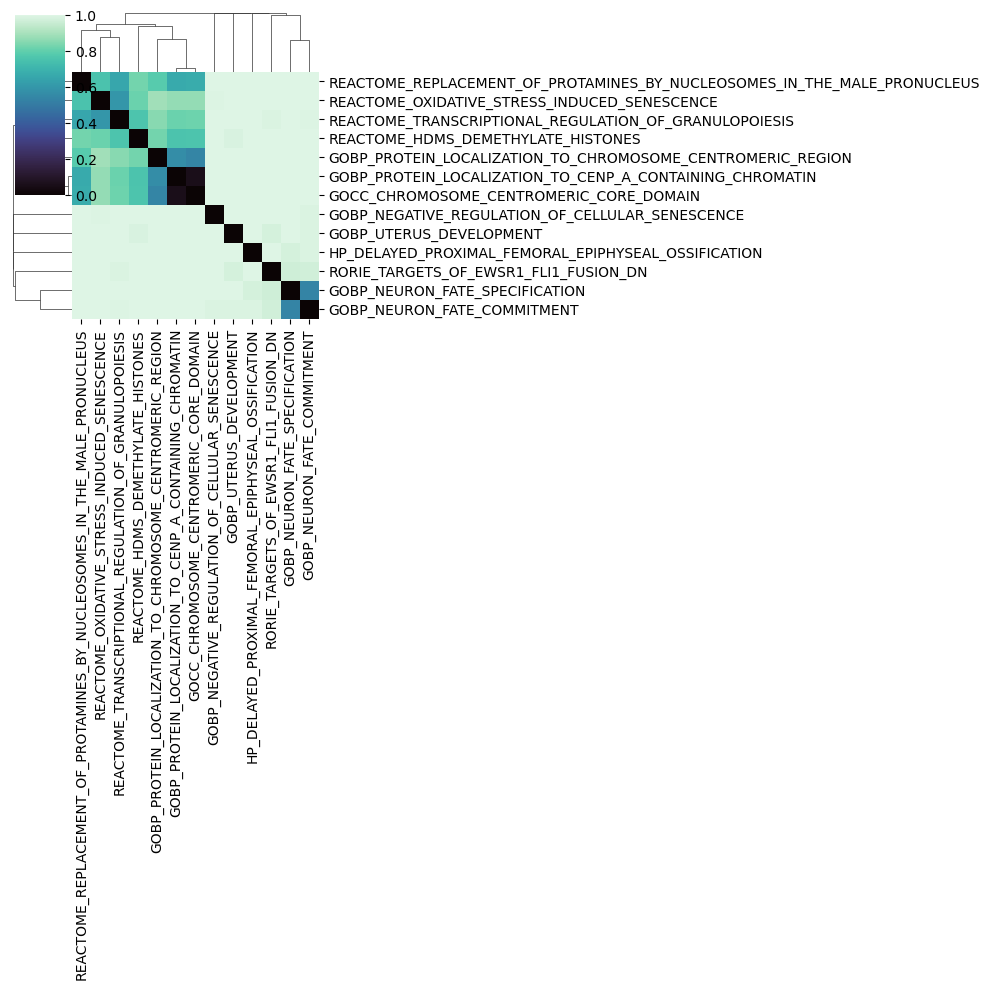

In [117]:
gmts = [
    '/Users/ochapman/projects/pedpancan_ecdna/2024-04-19_RNAseq/results/ec_ch_go_584576/gene_sets.gmt',
    '/Users/ochapman/projects/pedpancan_ecdna/2024-04-19_RNAseq/results/ec_ch_other_584575/gene_sets.gmt',
    '/Users/ochapman/projects/pedpancan_ecdna/2024-04-19_RNAseq/out/dsbr-sets.gmt',
    '/Users/ochapman/projects/pedpancan_ecdna/2024-04-19_RNAseq/out/histone-sets.gmt',
]
go_sets = parse_gmt(gmts)
plot = go_jaccard_matrix(go=False,include_histones=False)

In [118]:
def savefig(plot,basename):
    pdfName = basename + ".pdf"
    pngName = basename + ".png"
    svgName = basename + ".svg"
    plot.savefig(pdfName,format='pdf')
    plot.savefig(pngName,format='png')
    plot.savefig(svgName,format='svg')
savefig(plot,'figures/jaccard_matrix')